In [2]:
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [68]:
#lost code for this ds, but thankfully I had the csv saved. this is the same as the clean_speeddating_with_na.csv ds but I removed all the binned columns and the has_null column
df = pd.read_csv("clean_speeddating_removed_na_and_bins.csv", low_memory=False)
df.drop(df.columns[[0]], axis=1, inplace=True)
df.drop(['field'], axis=1, inplace=True)
df.shape

(4862, 61)

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [70]:
# split data into X and y
X = df.loc[:, df.columns != 'match']
y = df['match']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['match'], random_state=1)

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
#from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import StandardScaler

#make an encoder for all the categorical columns
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist')
categorical_cols = ["gender", "race", "race_o"]

#standard scale all numeric columns since some are on scale of 0-100 and some from 1-10 and some are binary (like same_race)
std_scaler = StandardScaler()
all_cols = df.columns.tolist()
numeric_cols = [col for col in all_cols if col not in categorical_cols]
numeric_cols.remove('match')

#now use a column transformer to do both pre processors on their separate columns
transformer = ColumnTransformer(
        [('categories', encoder, categorical_cols),
        ('numeric', std_scaler, numeric_cols)],
        remainder='drop', verbose_feature_names_out=False)

In [84]:
transformer.fit(X_train, y_train)

X_train_trans2 = transformer.transform(X_train)

X_train_trans_df2 = pd.DataFrame(X_train_trans2, columns = transformer.get_feature_names_out())

# fit model no training data
model = XGBClassifier(learning_rate =0.8)

model.fit(X_train_trans_df2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [85]:
X_test_trans = transformer.transform(X_test)


y_pred = model.predict(X_test_trans)
predictions = [round(value) for value in y_pred]

In [86]:

# evaluate predictions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1012
           1       0.60      0.43      0.50       204

    accuracy                           0.86      1216
   macro avg       0.75      0.68      0.71      1216
weighted avg       0.84      0.86      0.85      1216



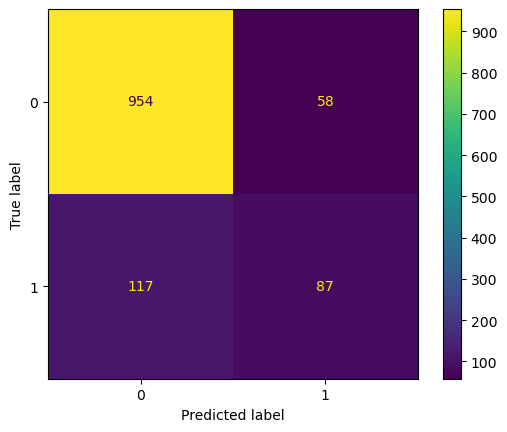

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred)).plot()